In [18]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, BatchNormalization, MaxPool2D, Dropout
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from tqdm import tqdm_notebook as tqdm

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
from Momentum import Momentum

In [3]:
batch_size = 256
num_classes = 10
epochs = 20

In [4]:
img_rows, img_cols = 28, 28

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [77]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

In [58]:
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [79]:
lrs = []

In [78]:
K1 = 0.
beta1 = 0.9

In [80]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    global K1
    
    if epoch == 0:
        K1 = 0.1
        return 0.1

    Kz = 0.  # max penultimate activation
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in tqdm(range((len(x_train) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        
        if activ > Kz:
            Kz = activ

    K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size) #+ 1e-3 * max_wt
    
    K1 = beta1 * K1 + (1 - beta1) * K_

    lr = 1 / K1
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr

In [81]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [82]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Momentum(lr=1e-3, decay=0.),
              metrics=['accuracy'])

In [83]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [84]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/20
235/234 [==============================] - 18s 76ms/step - loss: 0.5966 - acc: 0.8136 - val_loss: 0.0684 - val_acc: 0.9810
Epoch 2/20



Epoch 1 LR = 1.4273421500884764
235/234 [==============================] - 20s 84ms/step - loss: 0.2092 - acc: 0.9339 - val_loss: 0.0669 - val_acc: 0.9812
Epoch 3/20



Epoch 2 LR = 0.8057073446965183
235/234 [==============================] - 18s 76ms/step - loss: 0.0886 - acc: 0.9713 - val_loss: 0.0308 - val_acc: 0.9893
Epoch 4/20



Epoch 3 LR = 0.5788263811504591
235/234 [==============================] - 17s 74ms/step - loss: 0.0685 - acc: 0.9784 - val_loss: 0.0208 - val_acc: 0.9935
Epoch 5/20



Epoch 4 LR = 0.4617928198323472
235/234 [==============================] - 18s 77ms/step - loss: 0.0603 - acc: 0.9813 - val_loss: 0.0205 - val_acc: 0.9938
Epoch 6/20



Epoch 5 LR = 0.39069691366422427
235/234 [==============================] - 18s 76ms/step - loss: 0.0565 - acc: 0.9818 - val_loss: 0.0218 - val_acc: 0.9942
Epoch 7/20



Epoch 6 LR = 0.34314984623561584
235/234 [==============================] - 18s 75ms/step - loss: 0.0537 - acc: 0.9839 - val_loss: 0.0198 - val_acc: 0.9936
Epoch 8/20



Epoch 7 LR = 0.30927543951265224
235/234 [==============================] - 18s 77ms/step - loss: 0.0472 - acc: 0.9855 - val_loss: 0.0172 - val_acc: 0.9951
Epoch 9/20



Epoch 8 LR = 0.28404005179206826
235/234 [==============================] - 18s 75ms/step - loss: 0.0459 - acc: 0.9860 - val_loss: 0.0164 - val_acc: 0.9948
Epoch 10/20



Epoch 9 LR = 0.2646083597488736
235/234 [==============================] - 18s 76ms/step - loss: 0.0452 - acc: 0.9861 - val_loss: 0.0151 - val_acc: 0.9951
Epoch 11/20



Epoch 10 LR = 0.24926119290576607
235/234 [==============================] - 18s 78ms/step - loss: 0.0449 - acc: 0.9862 - val_loss: 0.0168 - val_acc: 0.9945
Epoch 12/20



Epoch 11 LR = 0.23689535069492398
235/234 [==============================] - 18s 75ms/step - loss: 0.0432 - acc: 0.9866 - val_loss: 0.0154 - val_acc: 0.9949
Epoch 13/20



Epoch 12 LR = 0.2267702886375761
235/234 [==============================] - 18s 76ms/step - loss: 0.0405 - acc: 0.9879 - val_loss: 0.0146 - val_acc: 0.9948
Epoch 14/20



Epoch 13 LR = 0.21837032723102903
235/234 [==============================] - 17s 73ms/step - loss: 0.0400 - acc: 0.9874 - val_loss: 0.0191 - val_acc: 0.9939
Epoch 15/20



Epoch 14 LR = 0.2113252612975103
235/234 [==============================] - 18s 77ms/step - loss: 0.0400 - acc: 0.9880 - val_loss: 0.0148 - val_acc: 0.9957
Epoch 16/20



Epoch 15 LR = 0.20536239772744203
235/234 [==============================] - 18s 76ms/step - loss: 0.0381 - acc: 0.9884 - val_loss: 0.0167 - val_acc: 0.9946
Epoch 17/20



Epoch 16 LR = 0.20027640477247438
235/234 [==============================] - 17s 74ms/step - loss: 0.0365 - acc: 0.9890 - val_loss: 0.0143 - val_acc: 0.9947
Epoch 18/20



Epoch 17 LR = 0.1959097054474397
235/234 [==============================] - 18s 76ms/step - loss: 0.0367 - acc: 0.9889 - val_loss: 0.0150 - val_acc: 0.9948
Epoch 19/20



Epoch 18 LR = 0.19213934970992935
235/234 [==============================] - 17s 74ms/step - loss: 0.0357 - acc: 0.9890 - val_loss: 0.0148 - val_acc: 0.9947
Epoch 20/20



Epoch 19 LR = 0.1888679978193955
235/234 [==============================] - 18s 78ms/step - loss: 0.0358 - acc: 0.9892 - val_loss: 0.0151 - val_acc: 0.9951


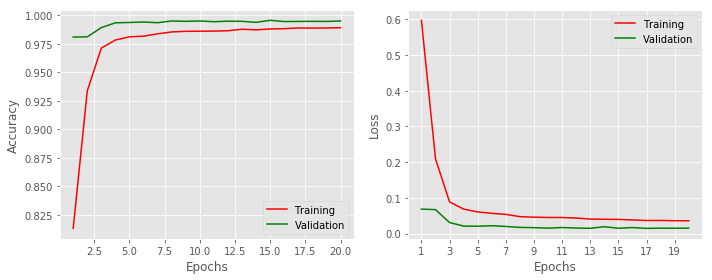

In [85]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
plt.xticks(range(1, 21, 2))

ax[0].set_ylabel('Accuracy');
ax[0].set_xlabel('Epochs');
lines = ax[0].plot(range(1, 21), model.history.history['acc'], 'r-',
                   range(1, 21), model.history.history['val_acc'], 'g-');
ax[0].legend(lines, ('Training', 'Validation'));

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
lines = ax[1].plot(range(1, 21), model.history.history['loss'], 'r-',
                   range(1, 21), model.history.history['val_loss'], 'g-');
ax[1].legend(lines, ('Training', 'Validation'))

fig.tight_layout()

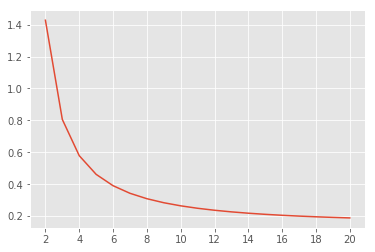

In [93]:
plt.xticks(range(2, 21, 2))
plt.plot(range(2, 21), lrs);